# Hisse Senetlerinin Sektörel Benzerlik Analizi ve Sınıflandırma Modeli Geliştirilmesi

<hr>

## 1.) Veri Yükleme

In [1]:
import yfinance as yf
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from tsfresh import extract_features


def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

In [2]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

C:\Users\asus\AppData\Local\Temp\ipykernel_3464\593417218.py:27: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]
C:\Users\asus\AppData\Local\Temp\ipykernel_3464\593417218.py:38: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]


In [3]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1272,11.96T,0.17%,15.88,19.97%,-0.56%,37.57%
1,Healthcare,1157,"8,050.42B",0.51%,59.35,3.19%,-0.64%,10.10%
2,Technology,769,21.51T,0.49%,45.77,14.62%,-1.02%,48.02%
3,Industrials,661,"5,902.02B",1.19%,29.37,7.25%,-0.60%,26.47%
4,Consumer Discretionary,561,"8,772.75B",0.75%,29.42,6.51%,-2.14%,38.69%
5,Materials,266,"2,035.83B",1.71%,27.95,6.33%,-1.00%,13.76%
6,Real Estate,263,"1,675.38B",3.78%,49.20,9.51%,-0.40%,13.67%
7,Energy,251,"3,613.08B",3.18%,13.25,8.18%,-0.05%,12.47%
8,Communication Services,245,"6,456.13B",1.46%,33.37,11.59%,-1.02%,40.95%
9,Consumer Staples,242,"4,229.57B",1.53%,29.62,4.90%,-0.38%,26.62%


In [4]:
def fetch_and_save_sector_data(sector_name, data_folder='data/stock_sectors', output_folder='processed_data'):
    """
    Belirtilen sektör için hisse senedi verisini indirir, işler ve CSV olarak kaydeder.

    Parametreler:
        sector_name (str): İşlem yapılacak sektörün adı (örneğin: 'healthcare', 'technology').
        data_folder (str): Sektör CSV dosyalarının bulunduğu klasör (varsayılan: 'data/stock_sectors').
        output_folder (str): İşlenen verilerin kaydedileceği klasör (varsayılan: 'processed_data').

    Çıktı:
        İşlenmiş veri `output_folder/sector_name_rolling.csv` olarak kaydedilir.
    """
    # Sektör dosyasını yükleme
    file_path = f"{data_folder}/{sector_name}.csv"
    df_sector = pd.read_csv(file_path)

    # 'Symbol' sütununu listeye çevirme ve temizleme
    symbol_list = df_sector['Symbol'].tolist()
    symbol_list = [ticker for ticker in symbol_list if isinstance(ticker, str) and ticker.strip()]

    if not symbol_list:
        print(f"Hata: {sector_name} sektörüne ait geçerli bir sembol bulunamadı.")
        return

    print(f"📥 {sector_name} sektörü için {len(symbol_list)} hisse senedi verisi indiriliyor...")

    # Hisse senedi verisini çekme
    df_sector_data = yf.download(symbol_list, interval='1mo', start='2005-01-01')

    # 'Close' sütunlarını seçme ve aylık yüzde değişim hesaplama
    df_sector_data = df_sector_data['Close'].resample('M').last().pct_change() + 1

    # Dosya kaydetme yolu
    output_file = f"{output_folder}/{sector_name}_rolling.csv"
    df_sector_data.to_csv(output_file)

    print(f"{sector_name} sektörü verisi başarıyla kaydedildi: {output_file}")

## 2.) Veri Ön İşleme

#### Healthcare

In [5]:
df_healthcare = pd.read_csv('healthcare_rolling.csv')

In [6]:
df_healthcare.dtypes

Date     object
A       float64
AADI    float64
AAPG    float64
ABBV    float64
         ...   
ZVRA    float64
ZVSA    float64
ZYBT    float64
ZYME    float64
ZYXI    float64
Length: 1166, dtype: object

In [7]:
df_healthcare.head()

,Date,A,AADI,AAPG,ABBV,ABCL,ABEO,ABOS,ABP,ABSI,...,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYBT,ZYME,ZYXI
0,2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-28,1.085482,NaN,NaN,NaN,NaN,1.081784,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.074071
2,2005-03-31,0.925000,NaN,NaN,NaN,NaN,0.855670,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.793105
3,2005-04-30,0.934685,NaN,NaN,NaN,NaN,1.004016,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.173915
4,2005-05-31,1.157108,NaN,NaN,NaN,NaN,0.952000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.111108


In [8]:
# 'Date' sütununu datetime formatına çevirelim
df_healthcare['Date'] = pd.to_datetime(df_healthcare['Date'])

# 'Date' sütununu index yap
df_healthcare.set_index('Date', inplace=True)

In [9]:
# 3 aylik momentum faktorleri
def get_rolling_ret(data, n): 
    return data.rolling(n).apply(np.prod)
df_healthcare = get_rolling_ret(df_healthcare, 3)# .dropna()
df_healthcare

,A,AADI,AAPG,ABBV,ABCL,ABEO,ABOS,ABP,ABSI,ABT,...,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYBT,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,0.938489,NaN,NaN,NaN,NaN,0.929368,NaN,NaN,NaN,1.098022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2005-05-31,1.000417,NaN,NaN,NaN,NaN,0.817869,NaN,NaN,NaN,1.054980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,0.923280,1.283871,NaN,1.110203,0.837423,1.308163,0.872727,1.029012,0.872727,1.075811,...,0.701799,0.800000,0.729167,0.995364,1.113924,1.255778,0.580925,NaN,1.309751,0.958889
2024-11-30,0.966902,1.292818,NaN,0.939284,1.175781,1.121053,0.828467,0.245767,0.693182,1.053498,...,1.040346,0.992248,1.226804,0.957356,0.738499,1.219608,0.389130,NaN,1.201194,1.058524
2024-12-31,0.906209,1.531553,NaN,0.907024,1.126923,0.881329,0.693548,0.159821,0.685864,0.996782,...,0.823370,0.875912,1.342857,0.835889,0.615764,1.201729,0.441667,NaN,1.166534,0.981618


In [10]:
df_healthcare.head()

,A,AADI,AAPG,ABBV,ABCL,ABEO,ABOS,ABP,ABSI,ABT,...,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYBT,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,0.938489,NaN,NaN,NaN,NaN,0.929368,NaN,NaN,NaN,1.098022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2005-05-31,1.000417,NaN,NaN,NaN,NaN,0.817869,NaN,NaN,NaN,1.054980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034483


In [11]:
df_healthcare.shape

(242, 1165)

In [12]:
# NaN değer bulunmayanların sayısını hesaplayalım
x = [col for col in df_healthcare.columns if df_healthcare[col].isnull().sum(axis=0) == 0]
x

[]

In [13]:
sorted_nan_counts = df_healthcare.isnull().sum(axis = 0).sort_values()

In [14]:
top_700_columns = sorted_nan_counts.head(700).index

In [15]:
df_healthcare_700 = df_healthcare[top_700_columns]

In [16]:
df_healthcare_700.head()

,A,IMNN,ILMN,IDXX,ICUI,ICLR,ICCC,ICAD,IART,HUM,...,PSNL,ADPT,BBIO,IMVT,FULC,PHR,HCAT,MIRM,CSTL,INMD
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,0.938489,0.55102,1.013416,0.978107,1.345103,0.946469,0.819392,1.127119,0.940287,1.011088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,1.000417,1.00000,1.269649,1.043942,1.076747,0.845015,0.833333,0.854762,0.901051,1.092876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_healthcare_700.shape

(242, 700)

In [18]:
df_healthcare_700['CTMX'].isnull().sum()

133

In [19]:
df_healthcare_700['CTMX'].iloc[:134]

Date
2005-01-31         NaN
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31         NaN
                ...   
2015-10-31         NaN
2015-11-30         NaN
2015-12-31         NaN
2016-01-31         NaN
2016-02-29    0.671525
Name: CTMX, Length: 134, dtype: float64

In [20]:
df_healthcare_700.iloc[134:,:].isnull().any().tolist()

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [21]:
# NaN değerlerini 0 ile doldur
df_healthcare_700_filled = df_healthcare_700.fillna(0)

In [22]:
df_healthcare_700_filled.head()

,A,IMNN,ILMN,IDXX,ICUI,ICLR,ICCC,ICAD,IART,HUM,...,PSNL,ADPT,BBIO,IMVT,FULC,PHR,HCAT,MIRM,CSTL,INMD
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-02-28,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-03-31,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-04-30,0.938489,0.55102,1.013416,0.978107,1.345103,0.946469,0.819392,1.127119,0.940287,1.011088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-31,1.000417,1.00000,1.269649,1.043942,1.076747,0.845015,0.833333,0.854762,0.901051,1.092876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Financial

In [23]:
df_financials = pd.read_csv('financials_rolling.csv')
df_financials.head()

,Date,AACT,AAM,AAME,AAMI,AB,ABCB,ABL,ABTS,AC,...,WU,WULF,XP,XYF,YHNA,YOTA,YRD,ZBAI,ZBAO,ZION
0,2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-28,NaN,NaN,0.990131,NaN,1.045343,1.057030,NaN,NaN,NaN,...,NaN,0.890000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974639
2,2005-03-31,NaN,NaN,1.006645,NaN,1.021240,0.942698,NaN,NaN,NaN,...,NaN,0.979133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.049573
3,2005-04-30,NaN,NaN,0.986799,NaN,0.953129,1.038465,NaN,NaN,NaN,...,NaN,0.724590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014634
4,2005-05-31,NaN,NaN,1.003345,NaN,1.010235,1.020115,NaN,NaN,NaN,...,NaN,1.108597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.011566


In [24]:
# NaN değer bulunmayanların sayısını hesaplayalım
y = [col for col in df_financials.columns if df_financials[col].isnull().sum(axis=0) == 0]
y

['Date']

In [25]:
# 'Date' sütununu datetime formatına çevir
df_financials['Date'] = pd.to_datetime(df_financials['Date'])

# 'Date' sütununu index yap
df_financials.set_index('Date', inplace=True)

In [26]:
# 3 aylik momentum faktorleri
df_financials = get_rolling_ret(df_financials, 3)# .dropna()
df_financials

,AACT,AAM,AAME,AAMI,AB,ABCB,ABL,ABTS,AC,ACGL,...,WU,WULF,XP,XYF,YHNA,YOTA,YRD,ZBAI,ZBAO,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,NaN,NaN,0.983553,NaN,1.017509,1.034789,NaN,NaN,NaN,1.088756,...,NaN,0.631429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.037925
2005-05-31,NaN,NaN,0.996678,NaN,0.983336,0.998650,NaN,NaN,NaN,1.076422,...,NaN,0.786517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.077250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,1.012093,NaN,1.032468,1.008061,1.072157,1.020562,0.896266,0.962634,1.051719,1.029025,...,0.923256,1.567308,1.020456,1.514265,NaN,1.005391,1.234958,1.118252,0.856576,1.016740
2024-11-30,1.013940,NaN,0.950000,1.278931,1.075490,1.143150,0.801175,1.268443,1.141792,0.890618,...,0.920702,1.809633,0.735470,1.590150,NaN,1.000890,1.157434,0.955882,0.863636,1.232287
2024-12-31,1.013850,NaN,0.905882,1.037445,1.085384,1.005344,0.773715,1.465957,1.014318,0.868061,...,0.906478,1.209402,0.660535,1.307967,NaN,1.018987,0.877396,1.050000,0.427676,1.157141


In [27]:
df_financials.head()

,AACT,AAM,AAME,AAMI,AB,ABCB,ABL,ABTS,AC,ACGL,...,WU,WULF,XP,XYF,YHNA,YOTA,YRD,ZBAI,ZBAO,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,NaN,NaN,0.983553,NaN,1.017509,1.034789,NaN,NaN,NaN,1.088756,...,NaN,0.631429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.037925
2005-05-31,NaN,NaN,0.996678,NaN,0.983336,0.998650,NaN,NaN,NaN,1.076422,...,NaN,0.786517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.077250


In [28]:
sorted_nan_counts_2 = df_financials.isnull().sum(axis = 0).sort_values()

In [29]:
top_700_columns_2 = sorted_nan_counts_2.head(700).index

In [30]:
df_financials_700 = df_financials[top_700_columns_2]

In [31]:
df_financials_700.head()

,IBCP,MBWM,MBI,MBCN,LYG,LNC,LKFN,LCNB,LARK,L,...,JXN,VBNK,SSBK,MTAL,ACT,ARBK,WINV,CION,PX,SDIG
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,0.892967,0.915481,0.881158,1.071055,0.963629,0.982403,0.887211,0.994714,1.026180,1.044526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,0.935504,0.938103,0.959181,1.066334,0.915972,0.979639,0.956804,1.047334,0.896765,1.058600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_financials_700.shape

(242, 700)

In [33]:
df_financials_700['ANY'].isnull().sum()

107

In [34]:
df_financials_700['ANY'].iloc[:108]

Date
2005-01-31         NaN
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31         NaN
                ...   
2013-08-31         NaN
2013-09-30         NaN
2013-10-31         NaN
2013-11-30         NaN
2013-12-31    2.526531
Name: ANY, Length: 108, dtype: float64

In [35]:
# NaN değerlerini 0 ile doldur
df_financials_700_filled = df_financials_700.fillna(0)

In [36]:
df_financials_700_filled.head()

,IBCP,MBWM,MBI,MBCN,LYG,LNC,LKFN,LCNB,LARK,L,...,JXN,VBNK,SSBK,MTAL,ACT,ARBK,WINV,CION,PX,SDIG
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-04-30,0.892967,0.915481,0.881158,1.071055,0.963629,0.982403,0.887211,0.994714,1.026180,1.044526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-31,0.935504,0.938103,0.959181,1.066334,0.915972,0.979639,0.956804,1.047334,0.896765,1.058600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Teknoloji

In [37]:
df_technology = pd.read_csv('technology_rolling.csv')

In [38]:
df_technology

,Date,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,...,ZBRA,ZENA,ZENV,ZEO,ZEPP,ZETA,ZI,ZM,ZS,ZUO
0,2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-28,NaN,1.166710,1.100753,1.151272,NaN,0.980806,1.085237,1.047301,1.023126,...,0.979187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-03-31,NaN,0.928890,0.990163,0.848837,NaN,0.945205,1.087773,1.061120,0.985826,...,0.952276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-04-30,NaN,0.865371,0.895464,0.850685,NaN,0.898551,0.885539,0.614619,0.943829,...,1.005685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-05-31,NaN,1.102607,1.098890,1.070853,NaN,1.072811,1.113839,1.108017,1.087071,...,0.891122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2024-10-31,1.091544,0.969571,0.966601,0.813639,0.925862,0.975501,0.923326,1.043661,0.973139,...,1.031459,NaN,0.880000,0.769231,0.737931,0.927925,1.070736,1.071695,1.057623,1.148492
238,2024-11-30,2.638925,1.050551,1.154878,0.870238,0.914605,1.055174,1.079171,0.975060,0.977321,...,1.065529,4.254808,1.242424,0.992308,0.978193,0.769509,0.990045,1.106369,1.142707,1.003030
239,2024-12-31,0.894226,1.056316,0.913587,0.941137,0.878418,0.970803,0.861900,1.158208,0.974364,...,0.948943,0.868927,1.420732,2.658915,0.828025,0.844601,0.960695,0.986939,0.873276,0.998993
240,2025-01-31,0.757461,0.942417,1.031593,0.973236,1.360927,1.094261,0.983741,0.919170,1.001540,...,1.014810,0.631990,1.081545,0.795918,1.076923,1.020011,0.979068,1.065311,1.122942,1.006048


In [39]:
# 'Date' sütununu datetime formatına çevir
df_technology['Date'] = pd.to_datetime(df_technology['Date'])

# 'Date' sütununu index yap
df_technology.set_index('Date', inplace=True)

In [40]:
# 3 aylik momentum faktorleri
df_technology = get_rolling_ret(df_technology, 3)# .dropna()
df_technology

,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADP,...,ZBRA,ZENA,ZENV,ZEO,ZEPP,ZETA,ZI,ZM,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,NaN,0.937842,0.975989,0.831325,NaN,0.833013,1.045372,0.683034,0.951969,1.002673,...,0.937758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,NaN,0.886313,0.974337,0.773256,NaN,0.911155,1.072923,0.722632,1.011467,1.023219,...,0.853419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,1.635602,1.018423,1.138099,0.675188,1.047075,1.047524,0.866636,1.062229,0.968050,1.106930,...,1.087645,NaN,0.694737,0.363027,1.405429,1.292250,0.972711,1.237417,1.008029,1.091510
2024-11-30,3.631718,1.037575,1.128276,0.679045,0.952882,1.064030,0.898191,0.965866,0.932156,1.118050,...,1.178412,NaN,0.947977,0.677165,1.046667,0.806513,1.106168,1.197018,1.033053,1.129693
2024-12-31,2.575821,1.075946,1.019843,0.666381,0.743842,0.999270,0.858820,1.178630,0.926687,1.063164,...,1.042936,NaN,1.553333,2.029586,0.597701,0.603084,1.018411,1.170204,1.055400,1.150812


In [41]:
df_technology.head()

,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADP,...,ZBRA,ZENA,ZENV,ZEO,ZEPP,ZETA,ZI,ZM,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,NaN,0.937842,0.975989,0.831325,NaN,0.833013,1.045372,0.683034,0.951969,1.002673,...,0.937758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,NaN,0.886313,0.974337,0.773256,NaN,0.911155,1.072923,0.722632,1.011467,1.023219,...,0.853419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
sorted_nan_counts = df_technology.isnull().sum(axis = 0).sort_values()

In [43]:
top_700_columns = sorted_nan_counts.head(700).index

In [44]:
df_technology_700 = df_technology[top_700_columns]

In [45]:
df_technology_700.head()

,MU,CRUS,TACT,CSCO,CSGS,INTZ,SYNA,CSPI,CTLP,SWKS,...,LYT,CNTM,SVRE,SELX,HKD,NXTT,ASTI,GCT,MOB,TGL
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,0.932757,0.917211,0.457458,0.957317,0.948675,0.675000,0.489075,0.754678,1.636364,0.687747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,0.954782,1.106838,0.552247,1.113663,1.112281,0.841791,0.804939,1.227785,0.941176,0.871901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_technology_700.shape

(242, 700)

In [47]:
df_technology_700['OCFT'].isnull().sum()

183

In [48]:
df_technology_700['OCFT'].iloc[:184]

Date
2005-01-31         NaN
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31         NaN
                ...   
2019-12-31         NaN
2020-01-31         NaN
2020-02-29         NaN
2020-03-31         NaN
2020-04-30    0.790094
Name: OCFT, Length: 184, dtype: float64

In [49]:
# NaN değerlerini 0 ile doldur
df_technology_700_filled = df_technology_700.fillna(0)

In [50]:
df_technology_700_filled.head()

,MU,CRUS,TACT,CSCO,CSGS,INTZ,SYNA,CSPI,CTLP,SWKS,...,LYT,CNTM,SVRE,SELX,HKD,NXTT,ASTI,GCT,MOB,TGL
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-04-30,0.932757,0.917211,0.457458,0.957317,0.948675,0.675000,0.489075,0.754678,1.636364,0.687747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-31,0.954782,1.106838,0.552247,1.113663,1.112281,0.841791,0.804939,1.227785,0.941176,0.871901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.) Özellik Mühendisliği

### tsfresh

#### Healthcare

In [51]:
# Veriyi uzun formata dönüştürme
df_long_healthcare = df_healthcare_700_filled.reset_index().melt(id_vars=["Date"], var_name="id", value_name="value")

# Sütunları yeniden adlandırma
df_long_healthcare.rename(columns={"Date": "time"}, inplace=True)

In [52]:
df_long_healthcare.head()

,time,id,value
0,2005-01-31,A,0.000000
1,2005-02-28,A,0.000000
2,2005-03-31,A,0.000000
3,2005-04-30,A,0.938489
4,2005-05-31,A,1.000417


In [53]:
df_long_healthcare.tail()

,time,id,value
169395,2024-10-31,INMD,0.942605
169396,2024-11-30,INMD,1.168761
169397,2024-12-31,INMD,0.985251
169398,2025-01-31,INMD,1.007611
169399,2025-02-28,INMD,0.923707


In [54]:
df_long_healthcare.shape

(169400, 3)

In [55]:
# Özellik çıkarma
extracted_features_healthcare = extract_features(df_long_healthcare, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


In [56]:
extracted_features_healthcare

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,1.0,1.0,248.712717,263.784531,0.094346,0.004375,-0.000234,1.041057,...,0.496896,0.889702,2.606167,1.730986,2.942108,4.109647,4.969563,5.326510,NaN,1.353611
AADI,0.0,0.0,1.0,1.0,77.666078,85.041914,0.081784,0.004912,-0.000549,0.000000,...,0.095013,0.178389,0.588251,0.982669,1.493720,1.875515,2.032296,2.088395,NaN,1.787319
ABBV,0.0,0.0,1.0,1.0,148.976020,158.255770,0.054676,0.004364,0.000297,0.917621,...,0.095013,0.142417,0.493416,1.330194,2.195903,2.937304,3.391746,3.589584,NaN,1.298166
ABEO,0.0,0.0,1.0,1.0,242.069320,313.510510,0.285779,0.003701,0.000058,0.891574,...,0.238762,0.681176,2.202286,1.691005,2.880498,3.963901,4.783969,5.256683,NaN,2.903198
ABT,0.0,0.0,1.0,1.0,246.512703,256.020559,0.069630,0.004533,-0.000086,1.036172,...,0.747946,1.223557,3.096729,1.751490,3.010593,4.167109,4.969204,5.310327,NaN,1.206596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTEK,0.0,0.0,1.0,1.0,169.877412,243.747979,0.183948,0.003870,-0.001390,0.748851,...,0.245836,0.473905,1.687120,1.368431,2.246167,3.071871,3.553923,3.725267,NaN,3.160147
ZTS,0.0,0.0,1.0,1.0,147.960442,155.669291,0.046352,0.004071,0.000048,0.921319,...,0.095013,0.142417,0.402649,1.377205,2.211098,2.970763,3.417351,3.571962,NaN,1.225522
ZVRA,0.0,0.0,1.0,1.0,113.662517,133.565319,0.126317,0.003456,-0.000269,0.000000,...,0.095013,0.142417,0.855058,1.264991,1.924724,2.479866,2.781501,2.945152,NaN,2.052393
ZYME,0.0,0.0,1.0,1.0,96.683012,111.171772,0.073629,0.004205,-0.000109,0.000000,...,0.095013,0.142417,0.594308,1.057239,1.607859,2.020985,2.249719,2.318239,NaN,1.696534


In [57]:
null_sutunlar = [col for col in extracted_features_healthcare.columns if extracted_features_healthcare[col].isnull().sum()]

In [58]:
extracted_features_healthcare[null_sutunlar]

,value__friedrich_coefficients__coeff_0__m_3__r_30,value__friedrich_coefficients__coeff_1__m_3__r_30,value__friedrich_coefficients__coeff_2__m_3__r_30,value__friedrich_coefficients__coeff_3__m_3__r_30,value__max_langevin_fixed_point__m_3__r_30,value__query_similarity_count__query_None__threshold_0.0
A,-0.182529,0.314203,-0.407184,0.295194,1.057813,NaN
AADI,NaN,NaN,NaN,NaN,NaN,NaN
ABBV,NaN,NaN,NaN,NaN,NaN,NaN
ABEO,0.151015,-0.649310,0.471308,0.050185,3.333506,NaN
ABT,-2.340448,6.055356,-5.428944,1.733027,1.048461,NaN
...,...,...,...,...,...,...
ZTEK,NaN,NaN,NaN,NaN,NaN,NaN
ZTS,NaN,NaN,NaN,NaN,NaN,NaN
ZVRA,NaN,NaN,NaN,NaN,NaN,NaN
ZYME,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
extracted_features_healthcare[null_sutunlar].isnull().sum()

value__friedrich_coefficients__coeff_0__m_3__r_30           460
value__friedrich_coefficients__coeff_1__m_3__r_30           460
value__friedrich_coefficients__coeff_2__m_3__r_30           460
value__friedrich_coefficients__coeff_3__m_3__r_30           460
value__max_langevin_fixed_point__m_3__r_30                  460
value__query_similarity_count__query_None__threshold_0.0    700
dtype: int64

In [60]:
extracted_features_healthcare.drop(columns = null_sutunlar, inplace = True)

In [61]:
extracted_features_healthcare.shape

(700, 777)

In [62]:
extracted_features_healthcare.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,1.0,1.0,248.712717,263.784531,0.094346,0.004375,-0.000234,1.041057,...,0.310241,0.496896,0.889702,2.606167,1.730986,2.942108,4.109647,4.969563,5.326510,1.353611
AADI,0.0,0.0,1.0,1.0,77.666078,85.041914,0.081784,0.004912,-0.000549,0.000000,...,0.047540,0.095013,0.178389,0.588251,0.982669,1.493720,1.875515,2.032296,2.088395,1.787319
ABBV,0.0,0.0,1.0,1.0,148.976020,158.255770,0.054676,0.004364,0.000297,0.917621,...,0.095013,0.095013,0.142417,0.493416,1.330194,2.195903,2.937304,3.391746,3.589584,1.298166
ABEO,0.0,0.0,1.0,1.0,242.069320,313.510510,0.285779,0.003701,0.000058,0.891574,...,0.131054,0.238762,0.681176,2.202286,1.691005,2.880498,3.963901,4.783969,5.256683,2.903198
ABT,0.0,0.0,1.0,1.0,246.512703,256.020559,0.069630,0.004533,-0.000086,1.036172,...,0.496573,0.747946,1.223557,3.096729,1.751490,3.010593,4.167109,4.969204,5.310327,1.206596


In [63]:
extracted_features_healthcare['label'] = 0

In [64]:
extracted_features_healthcare.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7,label
A,0.0,0.0,1.0,1.0,248.712717,263.784531,0.094346,0.004375,-0.000234,1.041057,...,0.496896,0.889702,2.606167,1.730986,2.942108,4.109647,4.969563,5.326510,1.353611,0
AADI,0.0,0.0,1.0,1.0,77.666078,85.041914,0.081784,0.004912,-0.000549,0.000000,...,0.095013,0.178389,0.588251,0.982669,1.493720,1.875515,2.032296,2.088395,1.787319,0
ABBV,0.0,0.0,1.0,1.0,148.976020,158.255770,0.054676,0.004364,0.000297,0.917621,...,0.095013,0.142417,0.493416,1.330194,2.195903,2.937304,3.391746,3.589584,1.298166,0
ABEO,0.0,0.0,1.0,1.0,242.069320,313.510510,0.285779,0.003701,0.000058,0.891574,...,0.238762,0.681176,2.202286,1.691005,2.880498,3.963901,4.783969,5.256683,2.903198,0
ABT,0.0,0.0,1.0,1.0,246.512703,256.020559,0.069630,0.004533,-0.000086,1.036172,...,0.747946,1.223557,3.096729,1.751490,3.010593,4.167109,4.969204,5.310327,1.206596,0


#### Financials

In [65]:
# Veriyi uzun formata dönüştürme
df_long_financials = df_financials_700_filled.reset_index().melt(id_vars=["Date"], var_name="id", value_name="value")

# Sütunları yeniden adlandırma
df_long_financials.rename(columns={"Date": "time"}, inplace=True)

In [66]:
df_long_financials.head()

,time,id,value
0,2005-01-31,IBCP,0.000000
1,2005-02-28,IBCP,0.000000
2,2005-03-31,IBCP,0.000000
3,2005-04-30,IBCP,0.892967
4,2005-05-31,IBCP,0.935504


In [67]:
df_long_financials.tail()

,time,id,value
169395,2024-10-31,SDIG,1.509804
169396,2024-11-30,SDIG,1.078838
169397,2024-12-31,SDIG,0.693069
169398,2025-01-31,SDIG,0.768398
169399,2025-02-28,SDIG,0.650962


In [68]:
df_long_financials.shape

(169400, 3)

In [69]:
# Özellik çıkarma
extracted_features_financials = extract_features(df_long_financials, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


In [70]:
extracted_features_financials

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
AAME,0.0,0.0,1.0,1.0,242.911316,258.306385,0.126337,0.004592,0.000091,0.991756,...,0.513251,0.907063,2.607578,1.711539,2.913768,4.103911,4.937165,5.311767,NaN,1.707441
AAMI,0.0,0.0,1.0,1.0,124.940643,134.134101,0.068249,0.003357,-0.000282,0.315684,...,0.095013,0.095013,0.431001,1.331373,2.079351,2.755056,3.046921,3.121447,NaN,1.582660
AB,0.0,0.0,1.0,1.0,246.145750,259.438331,0.090912,0.004305,-0.000138,1.033846,...,0.718659,1.152447,2.895840,1.768757,3.035345,4.246713,5.022330,5.332384,NaN,1.417240
ABCB,0.0,0.0,1.0,1.0,247.669890,264.100328,0.115146,0.004039,-0.000185,1.030357,...,0.730337,1.280545,3.012596,1.755060,3.026714,4.262869,5.060001,5.357320,NaN,1.521352
ABL,0.0,0.0,1.0,1.0,50.274427,52.992825,0.026440,0.003962,0.000111,0.000000,...,0.095013,0.142417,0.414012,0.666899,0.984024,1.162578,1.271105,1.312969,NaN,1.385279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XP,0.0,0.0,1.0,1.0,59.262809,65.965280,0.050316,0.004269,0.000515,0.000000,...,0.095013,0.178389,0.690995,0.737829,1.072835,1.311227,1.462804,1.497228,NaN,1.768018
XYF,0.0,0.0,1.0,1.0,77.843904,98.703404,0.084847,0.004478,-0.000353,0.000000,...,0.131054,0.178389,0.513089,0.877905,1.334027,1.686286,1.830256,1.888123,NaN,2.107632
YRD,0.0,0.0,1.0,1.0,114.245400,146.651847,0.116903,0.004933,0.000379,0.000000,...,0.142417,0.225655,0.909751,1.183576,1.803440,2.318079,2.644670,2.740062,NaN,2.375947
ZBAI,0.0,0.0,1.0,1.0,71.678993,123.197200,0.087474,0.006384,0.000487,0.000000,...,0.131054,0.178389,0.742658,0.792697,1.208956,1.570547,1.714778,1.738304,NaN,2.946701


In [71]:
null_sutunlar2 = [col for col in extracted_features_financials.columns if extracted_features_financials[col].isnull().sum()]

In [72]:
extracted_features_financials[null_sutunlar2]

,value__friedrich_coefficients__coeff_0__m_3__r_30,value__friedrich_coefficients__coeff_1__m_3__r_30,value__friedrich_coefficients__coeff_2__m_3__r_30,value__friedrich_coefficients__coeff_3__m_3__r_30,value__max_langevin_fixed_point__m_3__r_30,value__query_similarity_count__query_None__threshold_0.0
AAME,-0.093891,0.209948,-0.447585,0.341928,1.033347,NaN
AAMI,NaN,NaN,NaN,NaN,NaN,NaN
AB,0.082998,-0.411648,0.242915,0.101824,4.191655,NaN
ABCB,0.098614,-0.340011,0.001997,0.254814,3.187172,NaN
ABL,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
XP,NaN,NaN,NaN,NaN,NaN,NaN
XYF,NaN,NaN,NaN,NaN,NaN,NaN
YRD,NaN,NaN,NaN,NaN,NaN,NaN
ZBAI,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
extracted_features_financials[null_sutunlar2].isnull().sum()

value__friedrich_coefficients__coeff_0__m_3__r_30           318
value__friedrich_coefficients__coeff_1__m_3__r_30           318
value__friedrich_coefficients__coeff_2__m_3__r_30           318
value__friedrich_coefficients__coeff_3__m_3__r_30           318
value__max_langevin_fixed_point__m_3__r_30                  318
value__query_similarity_count__query_None__threshold_0.0    700
dtype: int64

In [74]:
extracted_features_financials.drop(columns = null_sutunlar2, inplace = True)

In [75]:
extracted_features_financials.shape

(700, 777)

In [76]:
extracted_features_financials.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
AAME,0.0,0.0,1.0,1.0,242.911316,258.306385,0.126337,0.004592,0.000091,0.991756,...,0.278911,0.513251,0.907063,2.607578,1.711539,2.913768,4.103911,4.937165,5.311767,1.707441
AAMI,0.0,0.0,1.0,1.0,124.940643,134.134101,0.068249,0.003357,-0.000282,0.315684,...,0.095013,0.095013,0.095013,0.431001,1.331373,2.079351,2.755056,3.046921,3.121447,1.582660
AB,0.0,0.0,1.0,1.0,246.145750,259.438331,0.090912,0.004305,-0.000138,1.033846,...,0.434288,0.718659,1.152447,2.895840,1.768757,3.035345,4.246713,5.022330,5.332384,1.417240
ABCB,0.0,0.0,1.0,1.0,247.669890,264.100328,0.115146,0.004039,-0.000185,1.030357,...,0.405028,0.730337,1.280545,3.012596,1.755060,3.026714,4.262869,5.060001,5.357320,1.521352
ABL,0.0,0.0,1.0,1.0,50.274427,52.992825,0.026440,0.003962,0.000111,0.000000,...,0.095013,0.095013,0.142417,0.414012,0.666899,0.984024,1.162578,1.271105,1.312969,1.385279


In [77]:
extracted_features_financials['label'] = 1

In [78]:
extracted_features_financials.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7,label
AAME,0.0,0.0,1.0,1.0,242.911316,258.306385,0.126337,0.004592,0.000091,0.991756,...,0.513251,0.907063,2.607578,1.711539,2.913768,4.103911,4.937165,5.311767,1.707441,1
AAMI,0.0,0.0,1.0,1.0,124.940643,134.134101,0.068249,0.003357,-0.000282,0.315684,...,0.095013,0.095013,0.431001,1.331373,2.079351,2.755056,3.046921,3.121447,1.582660,1
AB,0.0,0.0,1.0,1.0,246.145750,259.438331,0.090912,0.004305,-0.000138,1.033846,...,0.718659,1.152447,2.895840,1.768757,3.035345,4.246713,5.022330,5.332384,1.417240,1
ABCB,0.0,0.0,1.0,1.0,247.669890,264.100328,0.115146,0.004039,-0.000185,1.030357,...,0.730337,1.280545,3.012596,1.755060,3.026714,4.262869,5.060001,5.357320,1.521352,1
ABL,0.0,0.0,1.0,1.0,50.274427,52.992825,0.026440,0.003962,0.000111,0.000000,...,0.095013,0.142417,0.414012,0.666899,0.984024,1.162578,1.271105,1.312969,1.385279,1


#### Technology

In [79]:
# Veriyi uzun formata dönüştürme
df_long_technology = df_technology_700_filled.reset_index().melt(id_vars=["Date"], var_name="id", value_name="value")

# Sütunları yeniden adlandırma
df_long_technology.rename(columns={"Date": "time"}, inplace=True)

In [80]:
df_long_technology

,time,id,value
0,2005-01-31,MU,0.000000
1,2005-02-28,MU,0.000000
2,2005-03-31,MU,0.000000
3,2005-04-30,MU,0.932757
4,2005-05-31,MU,0.954782
...,...,...,...
169395,2024-10-31,TGL,0.401439
169396,2024-11-30,TGL,0.414085
169397,2024-12-31,TGL,0.141600
169398,2025-01-31,TGL,0.338710


In [81]:
df_long_technology.shape

(169400, 3)

In [82]:
# Özellik çıkarma
extracted_features_technology = extract_features(df_long_technology, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


In [83]:
extracted_features_technology

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
AAOI,0.0,0.0,1.0,1.0,153.151231,239.530184,0.199931,0.002981,-0.002227,0.621792,...,0.095013,0.178389,1.030824,1.370358,2.172768,2.880572,3.270870,3.405403,NaN,3.299861
AAPL,0.0,0.0,1.0,1.0,258.646621,287.004564,0.102826,0.003984,-0.000178,1.073343,...,0.554999,0.910087,2.505197,1.671157,2.808420,3.926889,4.830518,5.288270,NaN,1.498858
ACIW,0.0,0.0,1.0,1.0,247.531002,261.727879,0.105004,0.003862,-0.000328,1.023911,...,0.997932,1.528496,3.199351,1.754157,2.957059,4.108994,4.933701,5.320636,NaN,1.418452
ACLS,0.0,0.0,1.0,1.0,253.507728,291.281584,0.181226,0.003570,0.000132,1.019375,...,0.543982,0.918780,2.558145,1.729387,2.927527,4.011674,4.887795,5.291265,NaN,1.896721
ACMR,0.0,0.0,1.0,1.0,97.997644,132.724696,0.110861,0.005494,0.000481,0.000000,...,0.095013,0.142417,0.784558,0.958616,1.453288,1.877065,2.093457,2.190825,NaN,2.282014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZETA,0.0,0.0,1.0,1.0,46.937290,58.382268,0.038471,0.004138,0.000696,0.000000,...,0.083650,0.095013,0.367030,0.560523,0.807716,0.941006,1.047290,1.080313,NaN,1.618732
ZI,0.0,0.0,1.0,1.0,50.259358,49.953092,0.039635,0.003793,-0.000036,0.000000,...,0.095013,0.178389,0.492106,0.730444,1.038949,1.234702,1.337595,1.371604,NaN,1.284014
ZM,0.0,0.0,1.0,1.0,70.129061,81.467024,0.040570,0.004321,-0.000254,0.000000,...,0.131054,0.214292,0.554520,0.744281,1.147725,1.437230,1.597340,1.700842,NaN,1.859071
ZS,0.0,0.0,1.0,1.0,89.031173,106.408221,0.070313,0.004128,-0.000262,0.000000,...,0.095013,0.178389,0.590090,0.912968,1.387444,1.789805,1.992795,2.045097,NaN,1.760748


In [84]:
null_sutunlar3 = [col for col in extracted_features_technology.columns if extracted_features_technology[col].isnull().sum()]

In [85]:
extracted_features_technology[null_sutunlar3]

,value__friedrich_coefficients__coeff_0__m_3__r_30,value__friedrich_coefficients__coeff_1__m_3__r_30,value__friedrich_coefficients__coeff_2__m_3__r_30,value__friedrich_coefficients__coeff_3__m_3__r_30,value__max_langevin_fixed_point__m_3__r_30,value__query_similarity_count__query_None__threshold_0.0
AAOI,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,0.266562,-0.939379,0.749958,-0.044824,2.364038,NaN
ACIW,-0.357126,0.793424,-0.840305,0.423403,1.056753,NaN
ACLS,0.086822,-0.365195,0.165620,0.140304,3.537972,NaN
ACMR,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ZETA,NaN,NaN,NaN,NaN,NaN,NaN
ZI,NaN,NaN,NaN,NaN,NaN,NaN
ZM,NaN,NaN,NaN,NaN,NaN,NaN
ZS,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
extracted_features_technology[null_sutunlar3].isnull().sum()

value__friedrich_coefficients__coeff_0__m_3__r_30           436
value__friedrich_coefficients__coeff_1__m_3__r_30           436
value__friedrich_coefficients__coeff_2__m_3__r_30           436
value__friedrich_coefficients__coeff_3__m_3__r_30           436
value__max_langevin_fixed_point__m_3__r_30                  436
value__query_similarity_count__query_None__threshold_0.0    700
dtype: int64

In [87]:
extracted_features_technology.drop(columns = null_sutunlar3, inplace = True)

In [88]:
extracted_features_technology.shape

(700, 777)

In [89]:
extracted_features_technology.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
AAOI,0.0,0.0,1.0,1.0,153.151231,239.530184,0.199931,0.002981,-0.002227,0.621792,...,0.095013,0.095013,0.178389,1.030824,1.370358,2.172768,2.880572,3.270870,3.405403,3.299861
AAPL,0.0,0.0,1.0,1.0,258.646621,287.004564,0.102826,0.003984,-0.000178,1.073343,...,0.310194,0.554999,0.910087,2.505197,1.671157,2.808420,3.926889,4.830518,5.288270,1.498858
ACIW,0.0,0.0,1.0,1.0,247.531002,261.727879,0.105004,0.003862,-0.000328,1.023911,...,0.669431,0.997932,1.528496,3.199351,1.754157,2.957059,4.108994,4.933701,5.320636,1.418452
ACLS,0.0,0.0,1.0,1.0,253.507728,291.281584,0.181226,0.003570,0.000132,1.019375,...,0.310241,0.543982,0.918780,2.558145,1.729387,2.927527,4.011674,4.887795,5.291265,1.896721
ACMR,0.0,0.0,1.0,1.0,97.997644,132.724696,0.110861,0.005494,0.000481,0.000000,...,0.095013,0.095013,0.142417,0.784558,0.958616,1.453288,1.877065,2.093457,2.190825,2.282014


In [90]:
extracted_features_technology['label'] = 2

In [91]:
extracted_features_technology.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7,label
AAOI,0.0,0.0,1.0,1.0,153.151231,239.530184,0.199931,0.002981,-0.002227,0.621792,...,0.095013,0.178389,1.030824,1.370358,2.172768,2.880572,3.270870,3.405403,3.299861,2
AAPL,0.0,0.0,1.0,1.0,258.646621,287.004564,0.102826,0.003984,-0.000178,1.073343,...,0.554999,0.910087,2.505197,1.671157,2.808420,3.926889,4.830518,5.288270,1.498858,2
ACIW,0.0,0.0,1.0,1.0,247.531002,261.727879,0.105004,0.003862,-0.000328,1.023911,...,0.997932,1.528496,3.199351,1.754157,2.957059,4.108994,4.933701,5.320636,1.418452,2
ACLS,0.0,0.0,1.0,1.0,253.507728,291.281584,0.181226,0.003570,0.000132,1.019375,...,0.543982,0.918780,2.558145,1.729387,2.927527,4.011674,4.887795,5.291265,1.896721,2
ACMR,0.0,0.0,1.0,1.0,97.997644,132.724696,0.110861,0.005494,0.000481,0.000000,...,0.095013,0.142417,0.784558,0.958616,1.453288,1.877065,2.093457,2.190825,2.282014,2


### FutureSelection

Tüm verileri tek bir dataframe'de toplayalım.

In [117]:
df = pd.concat([extracted_features_healthcare, extracted_features_financials, extracted_features_technology], ignore_index=True)

In [118]:
df.shape

(2100, 778)

In [119]:
df.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7,label
0,0.0,0.0,1.0,1.0,248.712717,263.784531,0.094346,0.004375,-0.000234,1.041057,...,0.496896,0.889702,2.606167,1.730986,2.942108,4.109647,4.969563,5.326510,1.353611,0
1,0.0,0.0,1.0,1.0,77.666078,85.041914,0.081784,0.004912,-0.000549,0.000000,...,0.095013,0.178389,0.588251,0.982669,1.493720,1.875515,2.032296,2.088395,1.787319,0
2,0.0,0.0,1.0,1.0,148.976020,158.255770,0.054676,0.004364,0.000297,0.917621,...,0.095013,0.142417,0.493416,1.330194,2.195903,2.937304,3.391746,3.589584,1.298166,0
3,0.0,0.0,1.0,1.0,242.069320,313.510510,0.285779,0.003701,0.000058,0.891574,...,0.238762,0.681176,2.202286,1.691005,2.880498,3.963901,4.783969,5.256683,2.903198,0
4,0.0,0.0,1.0,1.0,246.512703,256.020559,0.069630,0.004533,-0.000086,1.036172,...,0.747946,1.223557,3.096729,1.751490,3.010593,4.167109,4.969204,5.310327,1.206596,0


In [120]:
X = df.drop(columns = 'label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [121]:
X_train

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
1592,0.0,0.0,1.0,1.0,253.682645,292.169955,0.191912,0.004244,-0.000335,1.021287,...,0.556467,0.869614,1.304280,3.086758,1.696483,2.855881,3.921877,4.789620,5.263334,2.103803
829,0.0,0.0,1.0,1.0,246.814125,256.702574,0.064626,0.003895,-0.000056,1.036235,...,0.396819,0.708631,1.175843,3.013327,1.758695,3.003417,4.202208,5.026263,5.381594,1.231717
414,0.0,0.0,1.0,1.0,110.645340,129.916398,0.096886,0.003817,0.000208,0.000000,...,0.095013,0.095013,0.142417,0.845992,1.152373,1.755846,2.228844,2.549413,2.651974,1.868927
704,0.0,0.0,1.0,1.0,50.274427,52.992825,0.026440,0.003962,0.000111,0.000000,...,0.095013,0.095013,0.142417,0.414012,0.666899,0.984024,1.162578,1.271105,1.312969,1.385279
755,0.0,0.0,1.0,1.0,242.574423,252.748005,0.111108,0.003944,-0.000206,1.001692,...,0.385004,0.662764,1.149709,2.958416,1.737728,2.959457,4.075986,4.904162,5.300796,1.434163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.0,0.0,1.0,1.0,246.115327,256.732377,0.082127,0.004075,0.000146,1.036758,...,0.384074,0.552648,0.962022,2.730076,1.767889,3.016635,4.196661,5.016772,5.380817,1.312398
1095,0.0,0.0,1.0,1.0,245.669365,261.535474,0.116519,0.004148,-0.000307,1.016532,...,0.556467,0.852465,1.346712,2.992752,1.727849,2.911627,3.997772,4.833602,5.306670,1.644429
1130,0.0,0.0,1.0,1.0,78.013653,82.633580,0.042788,0.003991,-0.000309,0.000000,...,0.047540,0.095013,0.178389,0.477764,0.908094,1.388807,1.751604,1.915563,1.977441,1.366333
1294,0.0,0.0,1.0,1.0,242.298194,260.678176,0.147504,0.004258,0.000182,0.988772,...,0.310241,0.630723,1.050375,2.692984,1.749751,2.980822,4.164762,4.970223,5.345572,1.838725


In [122]:
selector = DropConstantFeatures(tol = 0.9)
selector.fit(X_train)

DropConstantFeatures(tol=0.9)

In [123]:
X_train.shape

(1680, 777)

In [124]:
X_train = selector.transform(X_train)


In [125]:
X_train.shape

(1680, 727)

In [126]:
selector.features_to_drop_

['value__variance_larger_than_standard_deviation',
 'value__has_duplicate_max',
 'value__has_duplicate_min',
 'value__has_duplicate',
 'value__length',
 'value__first_location_of_minimum',
 'value__minimum',
 'value__symmetry_looking__r_0.0',
 'value__symmetry_looking__r_0.2',
 'value__symmetry_looking__r_0.25',
 'value__symmetry_looking__r_0.30000000000000004',
 'value__symmetry_looking__r_0.35000000000000003',
 'value__symmetry_looking__r_0.4',
 'value__symmetry_looking__r_0.45',
 'value__symmetry_looking__r_0.5',
 'value__symmetry_looking__r_0.55',
 'value__symmetry_looking__r_0.6000000000000001',
 'value__symmetry_looking__r_0.65',
 'value__symmetry_looking__r_0.7000000000000001',
 'value__symmetry_looking__r_0.75',
 'value__symmetry_looking__r_0.8',
 'value__symmetry_looking__r_0.8500000000000001',
 'value__symmetry_looking__r_0.9',
 'value__symmetry_looking__r_0.9500000000000001',
 'value__large_standard_deviation__r_0.05',
 'value__large_standard_deviation__r_0.1',
 'value__larg

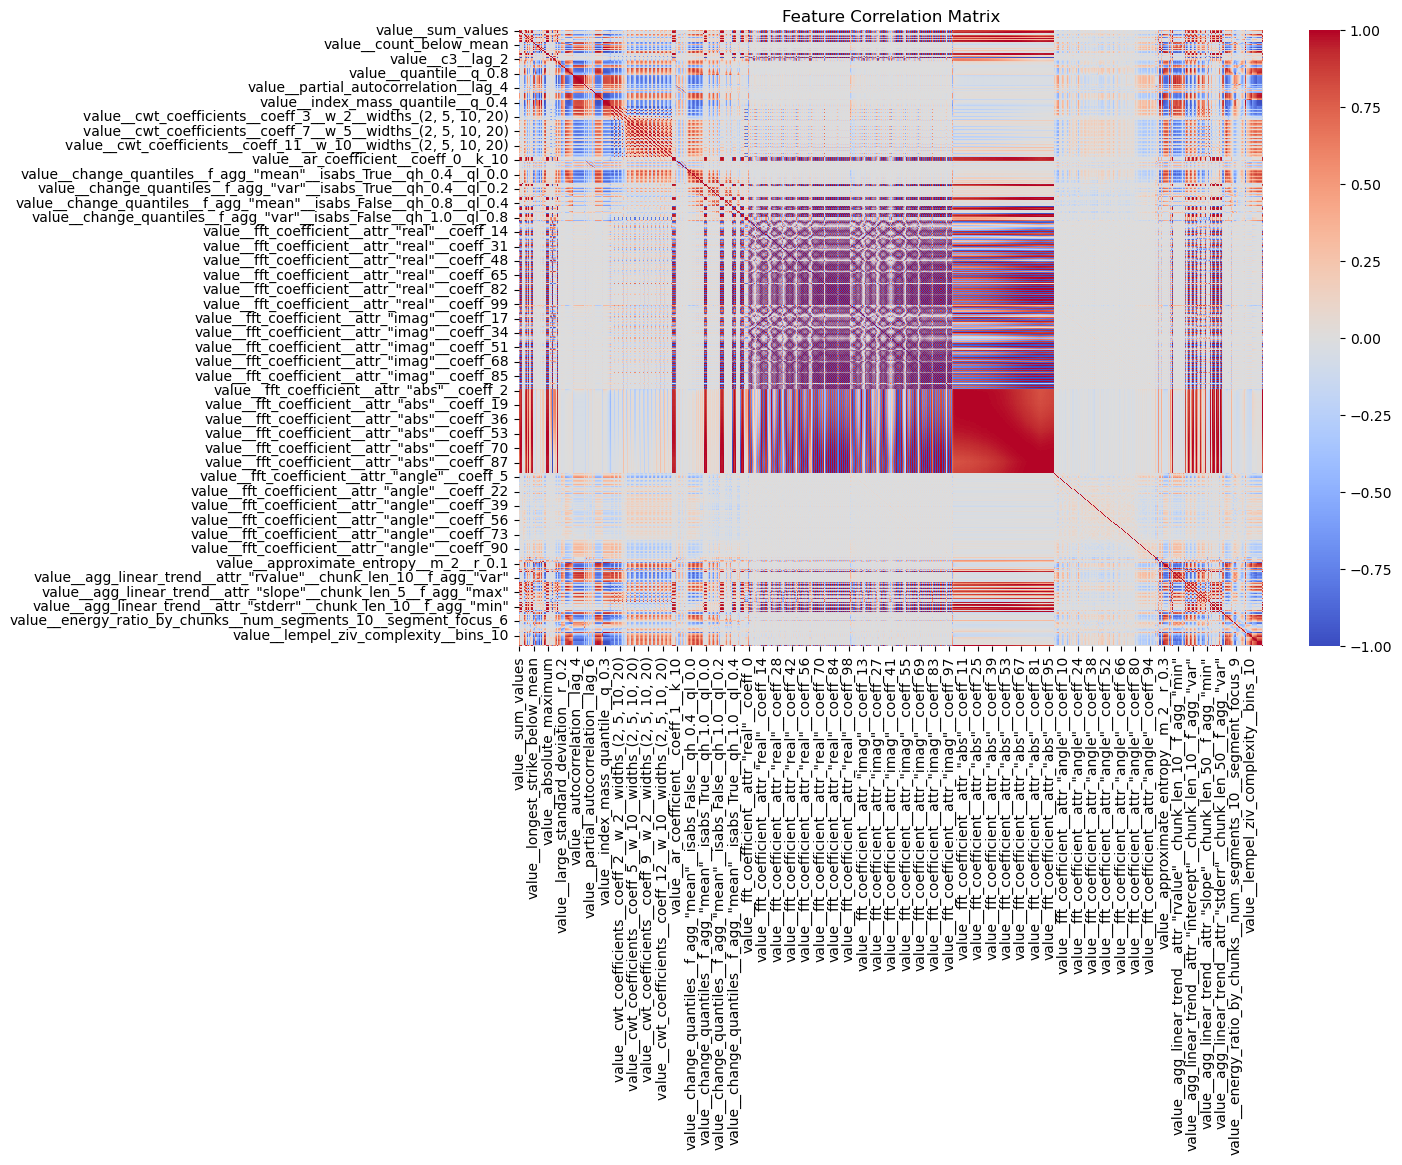

In [127]:
corr_matrix = X_train.corr()  # label sütunu hariç
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


In [128]:
selector2 = DropCorrelatedFeatures(method='pearson', threshold=0.90)
selector2.fit(X_train)

DropCorrelatedFeatures(threshold=0.9)

In [129]:
X_train = selector2.transform(X_train)
X_train

,value__abs_energy,value__mean_second_derivative_central,value__variation_coefficient,value__skewness,value__kurtosis,value__longest_strike_above_mean,value__count_above_mean,value__first_location_of_maximum,value__percentage_of_reoccurring_values_to_all_values,value__sum_of_reoccurring_data_points,...,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_10,value__fourier_entropy__bins_2,value__fourier_entropy__bins_10
1592,292.169955,-0.000335,0.314126,0.803463,3.818607,14.0,112.0,0.785124,0.004167,0.0,...,0.033058,0.033058,0.000000,0.000000,0.000000,0.165289,0.206612,0.330579,0.339257,1.304280
829,256.702574,-0.000056,0.140634,-4.508234,29.996120,11.0,140.0,0.789256,0.004167,0.0,...,0.012397,0.012397,0.012397,0.012397,0.012397,0.095041,0.123967,0.276860,0.196095,1.175843
414,129.916398,0.000208,1.252241,0.759474,-0.694317,102.0,102.0,0.793388,0.009709,0.0,...,0.012397,0.004132,0.000000,0.000000,0.000000,0.161157,0.169421,0.239669,0.047540,0.142417
704,52.992825,0.000111,2.018380,1.741373,1.843614,50.0,50.0,0.942149,0.019608,0.0,...,0.016529,0.008264,0.000000,0.000000,0.000000,0.107438,0.132231,0.157025,0.083650,0.142417
755,252.748005,-0.000206,0.198677,-1.370412,6.981248,17.0,119.0,0.264463,0.004167,0.0,...,0.016529,0.012397,0.012397,0.000000,0.000000,0.123967,0.214876,0.322314,0.219689,1.149709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,256.732377,0.000146,0.160300,-2.980672,17.259660,13.0,136.0,0.185950,0.004167,0.0,...,0.020661,0.016529,0.012397,0.012397,0.000000,0.099174,0.198347,0.289256,0.263285,0.962022
1095,261.535474,-0.000307,0.220641,-0.319560,7.312949,11.0,121.0,0.297521,0.004167,0.0,...,0.024793,0.020661,0.004132,0.000000,0.000000,0.198347,0.132231,0.297521,0.356341,1.346712
1130,82.633580,-0.000309,1.511860,0.947391,-0.914631,76.0,76.0,0.809917,0.012987,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.165289,0.210744,0.047540,0.178389
1294,260.678176,0.000182,0.273007,0.283187,3.285451,13.0,111.0,0.793388,0.004167,0.0,...,0.037190,0.024793,0.000000,0.000000,0.000000,0.223140,0.177686,0.347107,0.196095,1.050375


In [130]:
X_train.shape

(1680, 275)

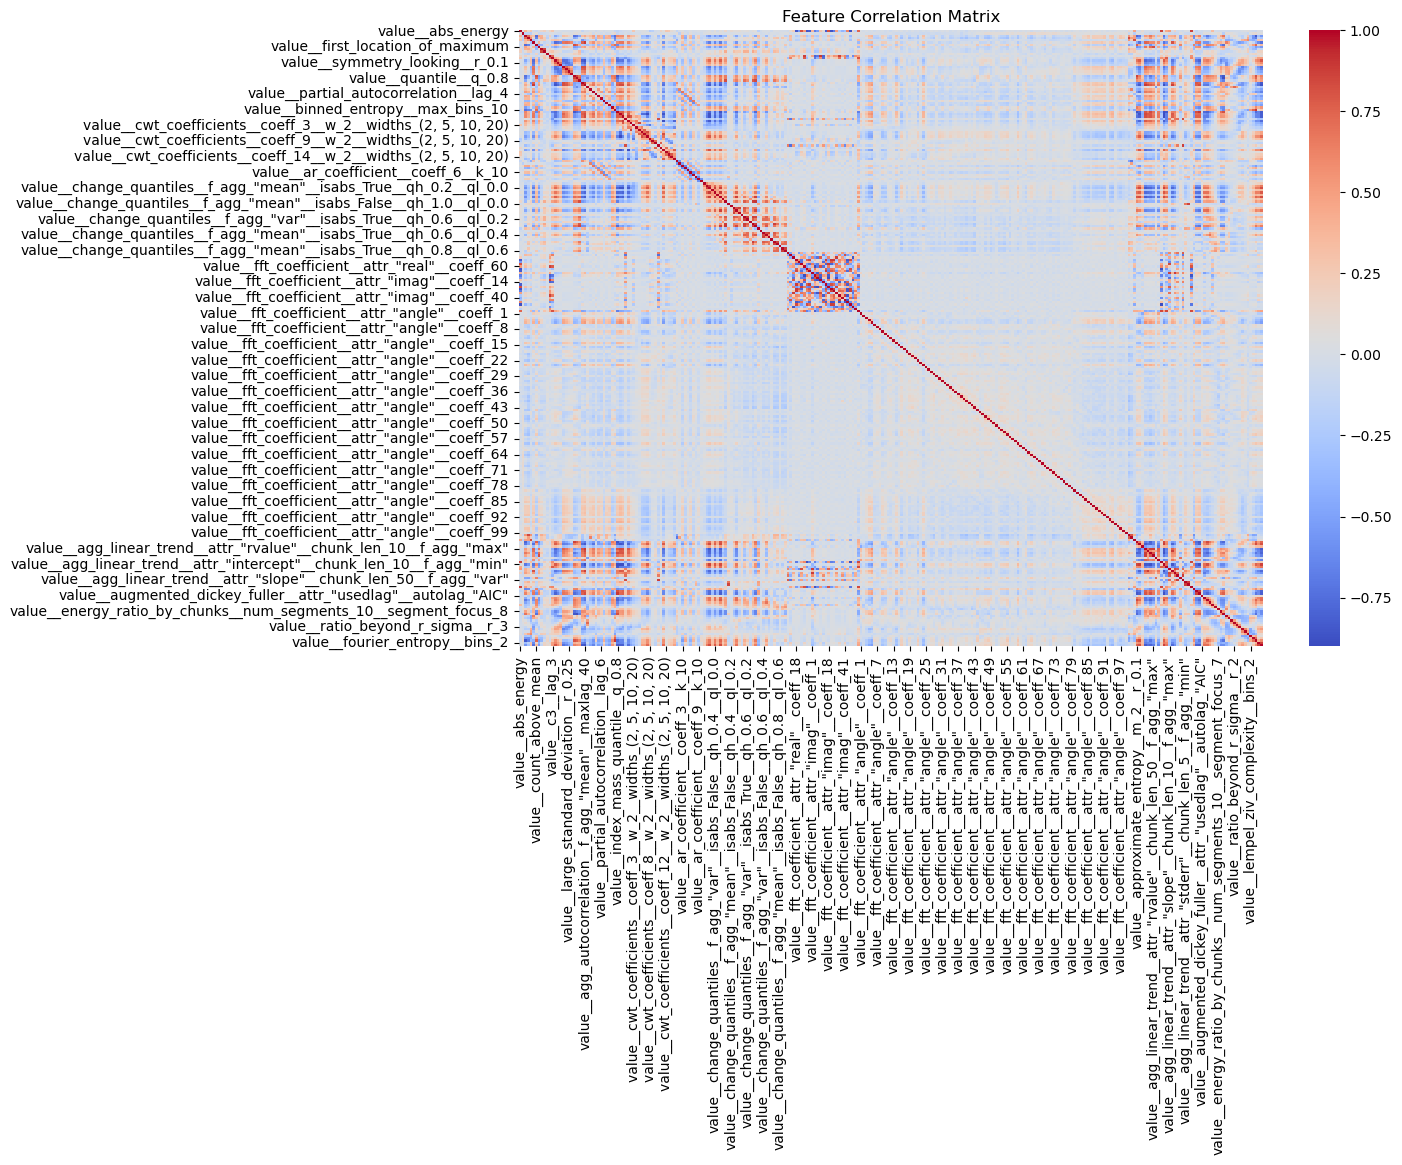

In [131]:
corr_matrix = X_train.corr()  # label sütunu hariç

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

Modelleyebilmek için bu aşamaları **test verisine de** uygulamalıyız.

## 4.) Modelleme

In [132]:
X_test = selector.transform(X_test)
X_test = selector2.transform(X_test)

In [133]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [134]:
acc = accuracy_score(y_test, y_pred)
acc

0.7404761904761905

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       152
           1       0.79      0.75      0.77       131
           2       0.66      0.68      0.67       137

    accuracy                           0.74       420
   macro avg       0.74      0.74      0.74       420
weighted avg       0.74      0.74      0.74       420



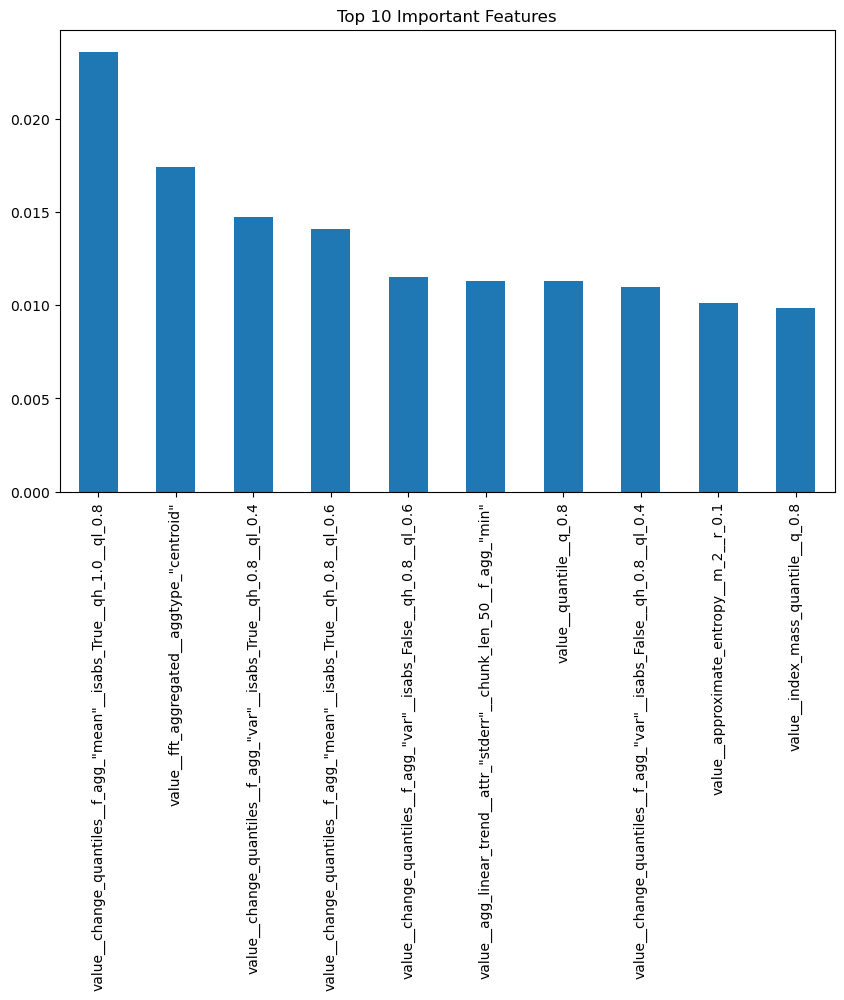

In [136]:
# Özellik önemlerini görselleştirme
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Bar grafiği ile görselleştirme
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind="bar")
plt.title("Top 10 Important Features")
plt.show()


<h3>SmartCorrelation </h3> ile de sonuca bakalım.

In [141]:
df = pd.concat([extracted_features_healthcare, extracted_features_financials, extracted_features_technology], ignore_index=True)

In [142]:
df.shape

(2100, 778)

In [143]:
X = df.drop(columns = 'label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [144]:
selector = DropConstantFeatures(tol = 0.9)
selector.fit(X_train)


DropConstantFeatures(tol=0.9)

In [145]:
X_train.shape

(1680, 777)

In [146]:
X_train = selector.transform(X_train)


In [147]:
X_train.shape

(1680, 727)

In [148]:
selector2 = SmartCorrelatedSelection(
    method="pearson",
    threshold=0.90,
    selection_method="model_performance",
    estimator=RandomForestClassifier(random_state=42),
    scoring="accuracy",
    cv=5,
)

selector2.fit(X_train, y_train.to_numpy().ravel())



SmartCorrelatedSelection(cv=5,
                         estimator=RandomForestClassifier(random_state=42),
                         scoring='accuracy',
                         selection_method='model_performance', threshold=0.9)

In [149]:
X_train = selector2.transform(X_train)
X_train

,value__sum_values,value__mean_second_derivative_central,value__variation_coefficient,value__skewness,value__kurtosis,value__longest_strike_above_mean,value__count_below_mean,value__first_location_of_maximum,value__percentage_of_reoccurring_values_to_all_values,value__benford_correlation,...,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3
1592,253.682645,-0.000335,0.314126,0.803463,3.818607,14.0,130.0,0.785124,0.004167,0.679770,...,0.000000,0.000000,0.000000,0.165289,0.206612,0.260331,0.330579,0.578512,0.339257,0.556467
829,246.814125,-0.000056,0.140634,-4.508234,29.996120,11.0,102.0,0.789256,0.004167,0.721827,...,0.012397,0.012397,0.012397,0.095041,0.123967,0.235537,0.276860,0.537190,0.196095,0.396819
414,110.645340,0.000208,1.252241,0.759474,-0.694317,102.0,140.0,0.793388,0.009709,0.643284,...,0.000000,0.000000,0.000000,0.161157,0.169421,0.202479,0.239669,0.351240,0.047540,0.095013
704,50.274427,0.000111,2.018380,1.741373,1.843614,50.0,192.0,0.942149,0.019608,0.657685,...,0.000000,0.000000,0.000000,0.107438,0.132231,0.148760,0.157025,0.194215,0.083650,0.095013
755,242.574423,-0.000206,0.198677,-1.370412,6.981248,17.0,123.0,0.264463,0.004167,0.582979,...,0.012397,0.000000,0.000000,0.123967,0.214876,0.235537,0.322314,0.582645,0.219689,0.385004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,246.115327,0.000146,0.160300,-2.980672,17.259660,13.0,106.0,0.185950,0.004167,0.699420,...,0.012397,0.012397,0.000000,0.099174,0.198347,0.214876,0.289256,0.557851,0.263285,0.384074
1095,245.669365,-0.000307,0.220641,-0.319560,7.312949,11.0,121.0,0.297521,0.004167,0.653695,...,0.004132,0.000000,0.000000,0.198347,0.132231,0.202479,0.297521,0.566116,0.356341,0.556467
1130,78.013653,-0.000309,1.511860,0.947391,-0.914631,76.0,166.0,0.809917,0.012987,0.712484,...,0.000000,0.000000,0.000000,0.136364,0.165289,0.169421,0.210744,0.289256,0.047540,0.047540
1294,242.298194,0.000182,0.273007,0.283187,3.285451,13.0,131.0,0.793388,0.004167,0.575483,...,0.000000,0.000000,0.000000,0.223140,0.177686,0.247934,0.347107,0.603306,0.196095,0.310241


In [150]:
X_train.shape

(1680, 275)

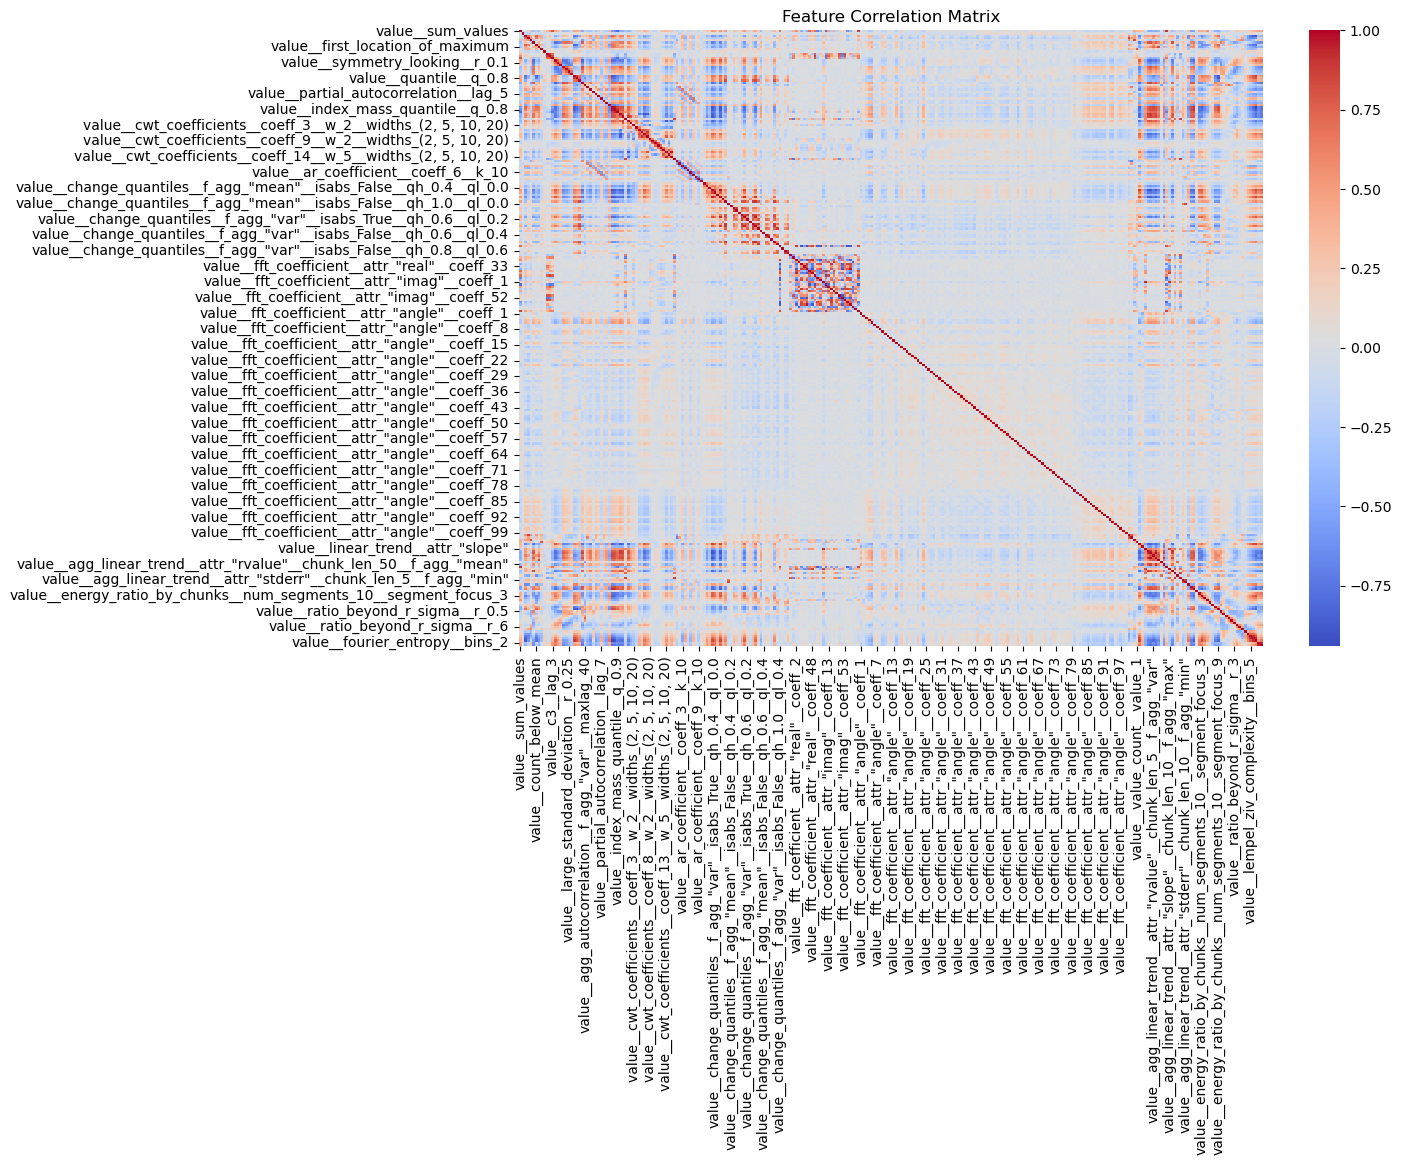

In [151]:
corr_matrix = X_train.corr()  # label sütunu hariç

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

In [152]:
X_test = selector.transform(X_test)
X_test = selector2.transform(X_test)

In [153]:
rf = RandomForestClassifier(n_estimators=80)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [154]:
acc = accuracy_score(y_test, y_pred)
acc

0.7404761904761905

In [155]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       152
           1       0.75      0.75      0.75       131
           2       0.69      0.65      0.67       137

    accuracy                           0.74       420
   macro avg       0.74      0.74      0.74       420
weighted avg       0.74      0.74      0.74       420



## 5.) Pipeline

In [177]:
df = pd.concat([extracted_features_healthcare, extracted_features_financials, extracted_features_technology], ignore_index=True)

In [178]:
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
# Pipeline (sadece veri ön işleme adımları)
preprocessing_pipeline = Pipeline(steps=[
    ('drop_constants', DropConstantFeatures(tol=0.9)),
    ('smart_correlated', SmartCorrelatedSelection(
        method="pearson",
        threshold=0.90,
        selection_method="model_performance",
        estimator=RandomForestClassifier(random_state=42),
        scoring="accuracy",
        cv=5
    ))
])
# Model (Random Forest)
model = RandomForestClassifier(random_state=42)

# Hiperparametreler
param_grid = {
    'n_estimators': [50, 80, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

In [180]:
# Pipeline'ı kullanarak eğitim verisini dönüştürme
X_train_transformed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [181]:
# Grid Search ile en iyi modeli bulma
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

# En iyi modeli kullanarak test seti üzerinde tahmin yapma
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)

In [182]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"En iyi hiperparametreler: {grid_search.best_params_}")
print(f"Test Seti Doğruluk Skoru: {accuracy}")
print("Sınıflandırma Raporu:")
print(classification_rep)

En iyi hiperparametreler: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 80}
Test Seti Doğruluk Skoru: 0.7357142857142858
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       152
           1       0.80      0.75      0.77       131
           2       0.66      0.66      0.66       137

    accuracy                           0.74       420
   macro avg       0.74      0.73      0.74       420
weighted avg       0.74      0.74      0.74       420



In [183]:
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, "best_model.pkl")

print("En iyi model başarıyla kaydedildi: best_model.pkl")

En iyi model başarıyla kaydedildi: best_model.pkl


In [184]:
# Pipeline'ı kaydet
joblib.dump(preprocessing_pipeline, "preprocessing_pipeline.pkl")
print("Ön işleme pipeline'ı başarıyla kaydedildi: preprocessing_pipeline.pkl")

Ön işleme pipeline'ı başarıyla kaydedildi: preprocessing_pipeline.pkl


## 6.) Yeni Verilerle Test Etme

In [185]:
import yfinance as yf
import joblib
import pandas as pd
from tsfresh import extract_features

def predict_stock(symbol):
    # Hisse verisini çekme
    test = yf.download(symbol, interval='1mo', start='2005-01-01')
    test = test['Close'].reset_index().melt(id_vars=["Date"], var_name="id", value_name="value")
    test.rename(columns={"Date": "time"}, inplace=True)
    
    # Özellik çıkarma
    extracted_features_test = extract_features(test, column_id="id", column_sort="time", column_value="value")
    
    # Pipeline ve modeli yükleme
    preprocessing_pipeline = joblib.load('preprocessing_pipeline.pkl')  # Ön işleme pipeline'ı
    best_model = joblib.load('best_model.pkl')  # En iyi modeli yükleme
    
    # Modelin gördüğü özellikleri almak için slicing yapıyoruz
    selected_columns = preprocessing_pipeline.feature_names_in_
    extracted_features_test = extracted_features_test[selected_columns]  # Modelin gördüğü özellikler seçildi
    
    # Ön işleme pipeline'ı ile veriyi dönüştürme
    test_transformed = preprocessing_pipeline.transform(extracted_features_test)
    
    # Tahmin yapma
    pred = best_model.predict(test_transformed)
    
    return pred

In [186]:
symbol = 'RELX' 
prediction = predict_stock(symbol)
print(f"{symbol} için tahmin edilen sınıf: {prediction}")

[*********************100%***********************]  1 of 1 completed
Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


RELX için tahmin edilen sınıf: [2]
